In [1]:
from scripts import train
from openunmix import our_data, model, utils, data
import importlib
import torch
import torchaudio

import matplotlib.pyplot as plt

In [2]:
dataset = our_data.ESMUC_Dataset_Isolated("~/ESMUC_dataset", split='valid')



In [18]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

target = "lowervoice-transformer"
unmix = utils.load_target_models(
            target, model_str_or_path="open-unmix", device=device, pretrained=True
        )[target]
print(unmix)
unmix = unmix.to(device)

separator = model.Separator({'vocals': unmix}, 0, nb_channels = 1).to(device)

OpenUnmix(
  (fc1): Linear(in_features=1487, out_features=512, bias=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc2): Linear(in_features=1024, out_features=512, bias=False)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, a

In [22]:

def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    _, axis = plt.subplots(1, 1)
    axis.imshow(spectrogram, cmap="viridis", vmin=-60, vmax=-10, origin="lower", aspect="auto")
    axis.set_title(title)
    plt.tight_layout()


x, y_corr = dataset[0]
print(x)
y = separator.forward(x.to(device).unsqueeze(0))

print(x, y, y_corr)

# plot_spectrogram(estimates[:, 0, 0, :].reshape(8000, 1).detach())
# plot_spectrogram(estimates[:, 1, 0, :].reshape(8000, 1).detach())

tensor([[ 0.1187,  0.1551,  0.1608,  ..., -0.0427, -0.0357, -0.0267]])
tensor([[ 0.1187,  0.1551,  0.1608,  ..., -0.0427, -0.0357, -0.0267]]) tensor([[[[0.1824, 0.1947, 0.2024,  ..., 0.0104, 0.0068, 0.0058]]]],
       device='cuda:0', grad_fn=<ViewBackward0>) tensor([[ 0.1333,  0.1437,  0.1548,  ..., -0.1030, -0.0862, -0.0600]])


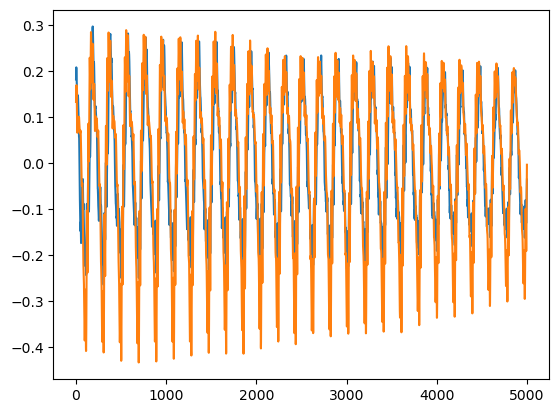

In [23]:
plt.plot(y.squeeze([0, 1, 2]).detach().to('cpu').numpy()[0:5000])
plt.plot(y_corr.squeeze(0)[0:5000])

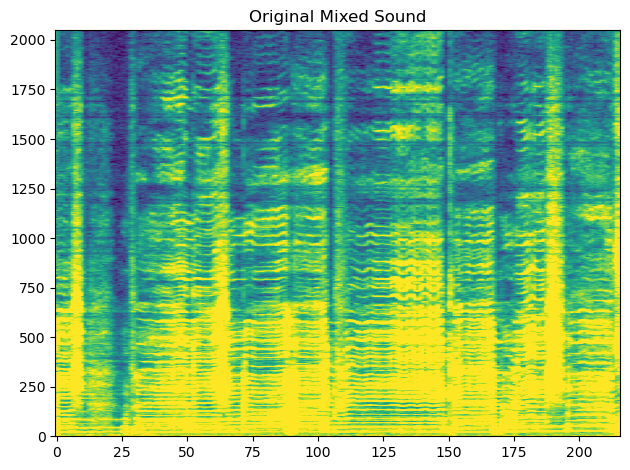

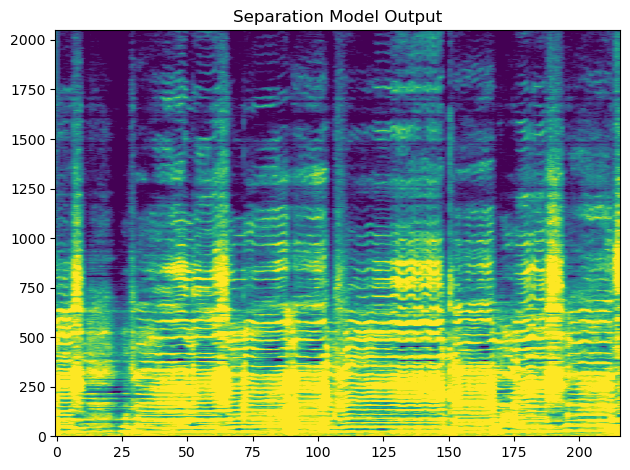

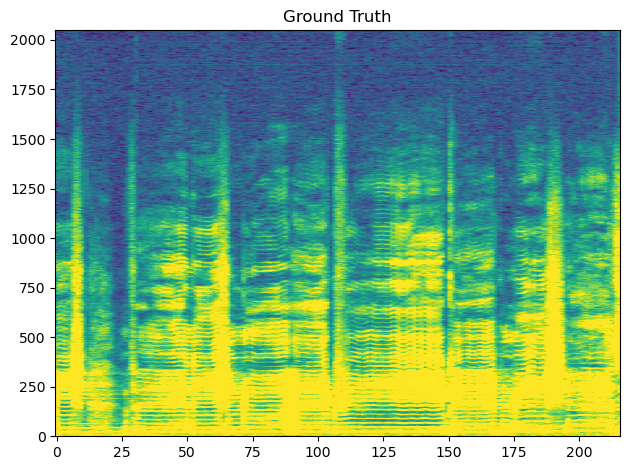

In [24]:
stft = torchaudio.transforms.Spectrogram(
    n_fft=4096,
    hop_length=1024,
    power=None,
).to(device)


plot_spectrogram(stft(x.to(device).squeeze(0).detach()).cpu(), "Original Mixed Sound")
plot_spectrogram(stft(y.squeeze([0, 1, 2]).detach()).cpu(), "Separation Model Output")
plot_spectrogram(stft(y_corr.to(device).squeeze(0)).cpu(), "Ground Truth")

In [30]:
import IPython.display as ipd
from IPython.display import Audio

print("Mixed Signal")
print(x.shape)
ipd.display(Audio(data=x, rate=dataset.sample_rate))
torchaudio.save("mixed.wav", x, dataset.sample_rate)

print("Model Output")
print(y.shape)
ipd.display(Audio(data=y.squeeze([0, 1, 2]).detach().cpu(), rate=dataset.sample_rate))
torchaudio.save("model_output.wav", y.squeeze([0, 1]).detach().cpu(), dataset.sample_rate)


print("Ground Truth")
ipd.display(Audio(data=y_corr, rate=dataset.sample_rate))
torchaudio.save("ground_truth.wav", y_corr, dataset.sample_rate)

Mixed Signal
torch.Size([1, 220500])


Model Output
torch.Size([1, 1, 1, 220500])


Ground Truth


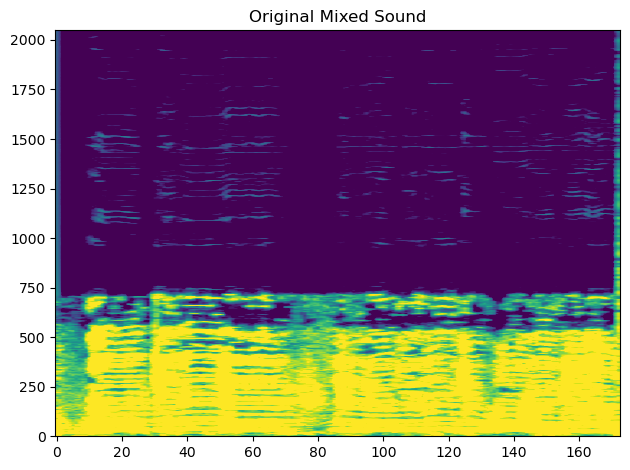

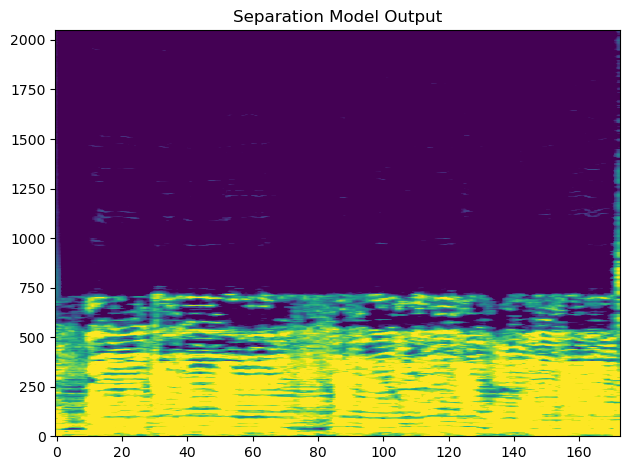

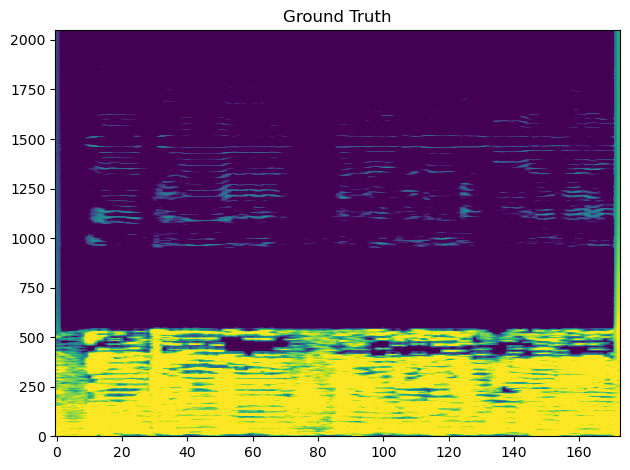

In [35]:
signal, sr = data.load_audio('uptown-girl.mp3')

y_corr = torchaudio.functional.resample(signal, sr, 44100)
_, mix = our_data.gen_overlaid_data(our_data.perfect_fourth, y_corr, 44100)

y = separator.forward(mix.to(device).unsqueeze(0))

plot_spectrogram(stft(mix.to(device).squeeze(0).detach()).cpu(), "Original Mixed Sound")
plot_spectrogram(stft(y.squeeze([0, 1, 2]).detach()).cpu(), "Separation Model Output")
plot_spectrogram(stft(y_corr.to(device).squeeze(0)).cpu(), "Ground Truth")

In [37]:
import IPython.display as ipd
from IPython.display import Audio

print("Mixed Signal")
ipd.display(Audio(data=mix, rate=dataset.sample_rate))
torchaudio.save("mixed_ug.wav", mix, dataset.sample_rate)


print("Model Output")
ipd.display(Audio(data=y.squeeze([0, 1, 2]).detach().cpu(), rate=dataset.sample_rate))
torchaudio.save("model_output_ug.wav", y.squeeze([0, 1]).detach().cpu(), dataset.sample_rate)


print("Ground Truth")
ipd.display(Audio(data=y_corr, rate=dataset.sample_rate))
torchaudio.save("ground_truth_ug.wav", y_corr, dataset.sample_rate)

Mixed Signal


Model Output


Ground Truth


In [66]:
unmix.nb_bins

1487